In [9]:
import os
import io
import requests
from PIL import Image, UnidentifiedImageError
from pathlib import Path
from typing import List, Optional
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, RandomRotation, ColorJitter
from torchvision import models
from torchvision.models import VGG19_Weights
import logging
import random
import matplotlib.pyplot as plt

In [2]:
RAW_IMAGES_DIR = Path("./data/original")
PROCESSED_IMAGES_DIR = Path("./data/train")
RAW_IMAGES_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_IMAGES_DIR.mkdir(parents=True, exist_ok=True)

PEXELS_API_KEY = "AA9PUGWGZcKuQDbUKDmbDfO8fj5OFPyThMLZPLx6gxDKXYXhKW4PWHnL"


def fetch_image_urls_from_pexels(query: str, total_images: int = 1000, batch_size: int = 30):
    headers = {"Authorization": PEXELS_API_KEY}
    image_urls = []
    page = 1

    while len(image_urls) < total_images:
        params = {"query": query, "per_page": batch_size, "page": page}
        try:
            response = requests.get("https://api.pexels.com/v1/search", headers=headers, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            photos = data.get("photos", [])
            if not photos:
                break
            for photo in photos:
                url = photo["src"]["original"]
                image_urls.append(url)
                if len(image_urls) >= total_images:
                    break
            page += 1
        except requests.RequestException as e:
            print(f"Error fetching images from Pexels: {e}")
            break

    return image_urls


def download_image(url: str, save_path: Path) -> None:
    if save_path.exists():
        return
    try:
        response = requests.get(url, stream=True, timeout=10)
        response.raise_for_status()
        with open(save_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
    except Exception as e:
        print(f"Failed to download {url}: {e}")


def preprocess_image(input_path: Path, output_path: Path, target_size: int = 500) -> None:
    if output_path.exists():
        return
    try:
        with Image.open(input_path) as img:
            img = img.convert("RGB")
            width, height = img.size
            min_side = min(width, height)
            left = (width - min_side) // 2
            upper = (height - min_side) // 2
            right = left + min_side
            lower = upper + min_side
            img = img.crop((left, upper, right, lower))
            img = img.resize((target_size, target_size), Image.LANCZOS)
            img.save(output_path, format="PNG")
    except Exception as e:
        print(f"Failed to preprocess {input_path}: {e}")


class LazyImageDataset(torch.utils.data.Dataset):
    def __init__(self, query: str, total_images: int = 1000):
        self.query = query
        self.urls = fetch_image_urls_from_pexels(query, total_images=total_images)
        self.total_images = len(self.urls)

    def __len__(self):
        return self.total_images

    def __getitem__(self, idx):
        url = self.urls[idx]
        image_name = os.path.basename(url.split("?")[0])
        raw_path = RAW_IMAGES_DIR / image_name
        processed_path = PROCESSED_IMAGES_DIR / image_name

        try:
            if not processed_path.exists():
                if not raw_path.exists():
                    download_image(url, raw_path)
                preprocess_image(raw_path, processed_path, target_size=500)
            img = Image.open(processed_path).convert("RGB")
            return img
        except (IOError, UnidentifiedImageError) as e:  # return a dummy image on error
            print(f"Error loading image {processed_path}: {e}")
            dummy_img = Image.new("RGB", (500, 500), color=(0, 0, 0))
            return dummy_img


base_dataset = LazyImageDataset(query="landscape", total_images=1000)

In [3]:
import matplotlib.pyplot as plt

img = base_dataset[0]
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
class SuperResolutionDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, scale_pairs=[(256, 512)], transform=ToTensor()):
        self.base_dataset = base_dataset
        self.transform = transform
        self.scale_pairs = scale_pairs
        self.index_scale_map = [scale_pairs[i % len(scale_pairs)] for i in range(len(base_dataset))]

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        try:
            img = self.base_dataset[idx]
            img = img.convert("RGB")

            low_res_size, target_size = self.index_scale_map[idx]
            lr_img = img.resize((low_res_size, low_res_size), Image.BICUBIC)
            hr_img = img.resize((target_size, target_size), Image.BICUBIC)

            if self.transform:
                lr_img = self.transform(lr_img)
                hr_img = self.transform(hr_img)

            return lr_img, hr_img
        except Exception as e:  # the same, return dummy images on error, to not fail entire training
            print(f"Error processing index {idx}: {e}")
            low_res_size, target_size = self.index_scale_map[idx]
            dummy_lr = torch.zeros(3, low_res_size, low_res_size)
            dummy_hr = torch.zeros(3, target_size, target_size)
            return dummy_lr, dummy_hr


sr_dataset = SuperResolutionDataset(
    base_dataset,
    scale_pairs=[(256, 512)],
)

train_size = int(0.8 * len(sr_dataset))
val_size = len(sr_dataset) - train_size
train_dataset, val_dataset = random_split(sr_dataset, [train_size, val_size])

batch_size = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # not working with >0
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,  # not working with >0
    pin_memory=True,
    drop_last=False
)

In [ ]:
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, _ = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image = images[i].permute(1, 2, 0)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out


class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, upscale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x


class EnhancedSuperResolutionModel(nn.Module):
    def __init__(self, num_res_blocks=16, base_channels=64, upscale_factor=2):
        super(EnhancedSuperResolutionModel, self).__init__()
        self.conv_input = nn.Conv2d(3, base_channels, kernel_size=9, padding=4)
        self.prelu = nn.PReLU()

        # residual blocks
        res_blocks = []
        for _ in range(num_res_blocks):
            res_blocks.append(ResidualBlock(base_channels))
        self.residual_layers = nn.Sequential(*res_blocks)

        self.conv_mid = nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1)
        self.bn_mid = nn.BatchNorm2d(base_channels)

        # upsampling blocks
        upsample_blocks = []
        num_upsample = int(torch.log2(torch.tensor(upscale_factor)).item())
        for _ in range(num_upsample):
            upsample_blocks.append(UpsampleBlock(base_channels, upscale_factor=2))
        self.upsample_layers = nn.Sequential(*upsample_blocks)

        self.conv_output = nn.Conv2d(base_channels, 3, kernel_size=9, padding=4)

    def forward(self, x):
        x = self.conv_input(x)
        x = self.prelu(x)

        residual = self.residual_layers(x)
        residual = self.conv_mid(residual)
        residual = self.bn_mid(residual)
        x = x + residual

        x = self.upsample_layers(x)
        x = self.conv_output(x)
        return x


class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        # Updated to use 'weights' instead of 'pretrained'
        vgg = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(vgg.features)[:35]).eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, sr, hr):
        sr_features = self.feature_extractor(sr)
        hr_features = self.feature_extractor(hr)
        loss = nn.functional.l1_loss(sr_features, hr_features)
        return loss

In [6]:
def train_epoch(model, dataloader, criterion_content, criterion_perceptual, optimizer, device):
    model.train()
    epoch_loss = 0.0
    for batch_idx, (lr, hr) in enumerate(dataloader):
        print(f"Batch {batch_idx + 1}/{len(dataloader)}")
        try:
            lr = lr.to(device)
            hr = hr.to(device)

            optimizer.zero_grad()
            sr = model(lr)

            loss_content = criterion_content(sr, hr)
            loss_perceptual = criterion_perceptual(sr, hr)
            loss = loss_content + 0.1 * loss_perceptual

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        except Exception as e:
            logging.error(f"Error in training batch {batch_idx + 1}: {e}")
            continue

    avg_loss = epoch_loss / len(dataloader)
    return avg_loss


def validate_epoch(model, dataloader, criterion_content, criterion_perceptual, device):
    model.eval()
    epoch_lost = 0.0
    with torch.no_grad():
        for batch_idx, (lr, hr) in enumerate(dataloader):
            try:
                lr = lr.to(device)
                hr = hr.to(device)

                sr = model(lr)

                loss_content = criterion_content(sr, hr)
                loss_perceptual = criterion_perceptual(sr, hr)
                loss = loss_content + 0.1 * loss_perceptual

                epoch_lost += loss.item()
            except Exception as e:
                logging.error(f"Error in validation batch {batch_idx + 1}: {e}")
                continue

    avg_loss = epoch_lost / len(dataloader)
    return avg_loss


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedSuperResolutionModel(num_res_blocks=16, base_channels=64, upscale_factor=2).to(device)
criterion_content = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10  # Increased number of epochs for better training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = EnhancedSuperResolutionModel(num_res_blocks=16, base_channels=64, upscale_factor=2).to(device)
criterion_content = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

num_epochs = 50

best_valid_loss = float('inf')
checkpoint_path = 'best_super_resolution.pth'

Using device: cpu


In [8]:
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

    train_loss = train_epoch(model, train_loader, criterion_content, criterion_perceptual, optimizer, device)
    print(f"Training Loss: {train_loss:.6f}")

    valid_loss = validate_epoch(model, val_loader, criterion_content, criterion_perceptual, device)
    print(f"Validation Loss: {valid_loss:.6f}")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {valid_loss:.6f}")

    scheduler.step()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Saved Best Model with Validation Loss: {best_valid_loss:.6f}")
    else:
        print("No improvement in validation loss.")



Epoch [1/20]


Training:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\kozub\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 3, 128, 128])) that is different to the input size (torch.Size([16, 3, 127, 127])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training:   0%|          | 0/50 [00:02<?, ?it/s]


RuntimeError: The size of tensor a (127) must match the size of tensor b (128) at non-singleton dimension 3

### checking

In [5]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#
# model = SuperResolutionNet(num_residuals=16, up_scale=2).to(device)
# model.load_state_dict(torch.load('best_super_resolution.pth', map_location=device))
# model.eval()

C:\Users\kozub\AppData\Local\Temp\ipykernel_3640\3397455569.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_super_resolution.pth',

SuperResolutionNet(
  (initial_conv): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (relu): ReLU(inplace=True)
  (residuals): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64

In [6]:
# def iterative_upscale(model, image, num_iterations=4, device='cpu'):
#     model.eval()
#     with torch.no_grad():
#         sr_image = image.unsqueeze(0).to(device)
#         for _ in range(num_iterations):
#             sr_image = model(sr_image)
#         return sr_image.squeeze(0).cpu()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


def visualize_and_save_results(model, dataloader, device, num_samples=5, output_dir='results'):
    model.eval()

    os.makedirs(output_dir, exist_ok=True)

    lr_dir = os.path.join(output_dir, 'lr')
    sr_dir = os.path.join(output_dir, 'sr')
    hr_dir = os.path.join(output_dir, 'hr')
    plot_dir = os.path.join(output_dir, 'plots')
    os.makedirs(lr_dir, exist_ok=True)
    os.makedirs(sr_dir, exist_ok=True)
    os.makedirs(hr_dir, exist_ok=True)
    os.makedirs(plot_dir, exist_ok=True)

    saved = 0
    with torch.no_grad():
        for batch_idx, (lr, hr) in enumerate(dataloader):
            lr = lr.to(device)
            sr = model(lr)

            sr = sr.cpu().numpy().transpose(0, 2, 3, 1)
            hr = hr.cpu().numpy().transpose(0, 2, 3, 1)
            lr = lr.cpu().numpy().transpose(0, 2, 3, 1)

            batch_size = lr.shape[0]
            for j in range(batch_size):
                if saved >= num_samples:
                    print(f"Saved {saved} samples. Exiting visualization.")
                    return

                lr_img = (lr[j] * 255.0).clip(0, 255).astype(np.uint8)
                sr_img = (sr[j] * 255.0).clip(0, 255).astype(np.uint8)
                hr_img = (hr[j] * 255.0).clip(0, 255).astype(np.uint8)

                lr_pil = Image.fromarray(lr_img)
                sr_pil = Image.fromarray(sr_img)
                hr_pil = Image.fromarray(hr_img)

                base_filename = f'sample_{saved + 1:03d}'

                lr_pil.save(os.path.join(lr_dir, f'{base_filename}_lr.png'))
                sr_pil.save(os.path.join(sr_dir, f'{base_filename}_sr.png'))
                hr_pil.save(os.path.join(hr_dir, f'{base_filename}_hr.png'))

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.title("Low-Resolution")
                plt.imshow(lr_img)
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("Super-Resolved")
                plt.imshow(sr_img)
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title("High-Resolution")
                plt.imshow(hr_img)
                plt.axis('off')

                plot_path = os.path.join(plot_dir, f'{base_filename}_comparison.png')
                plt.savefig(plot_path)
                plt.show()
                plt.close()

                saved += 1

    print(f"Total saved samples: {saved}")


visualize_and_save_results(model, val_loader, device, num_samples=3, output_dir='final_results')

In [1]:
print("helo")

helo


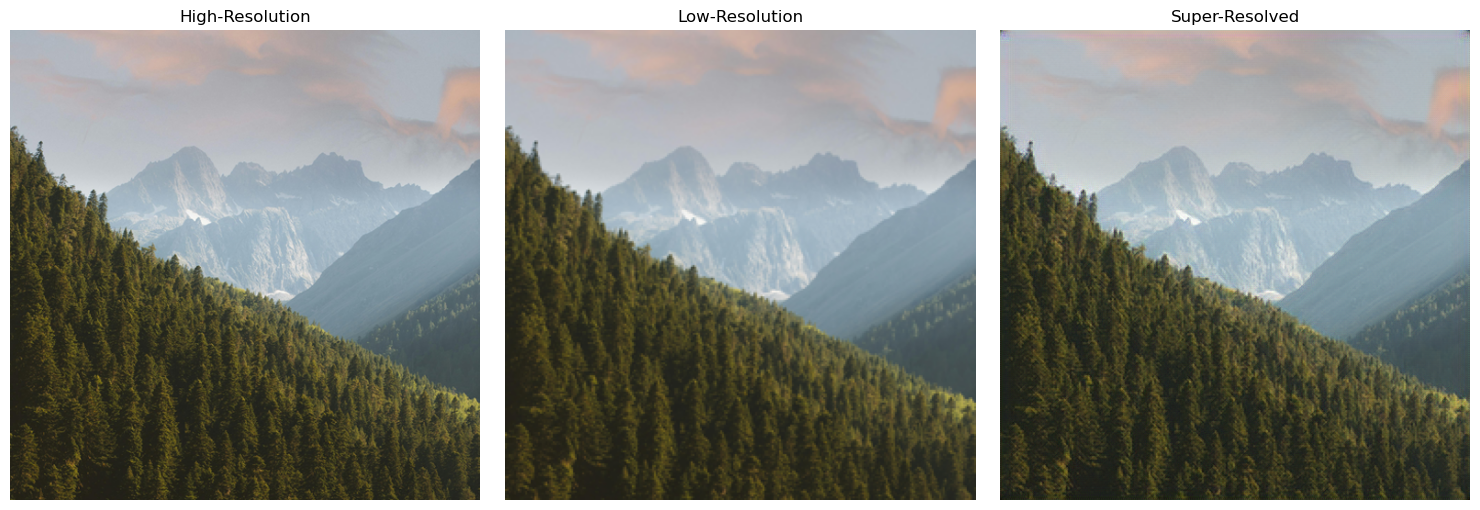

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt


def display_images(images_path, prefix):
    filenames = ['HR', 'LR', 'SR']

    images = [Image.open(os.path.join(images_path, prefix + "_" + filename + ".png")) for filename in filenames]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ['High-Resolution', 'Low-Resolution', 'Super-Resolved']

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


display_images('final_results', prefix='sample_1')

In [14]:
# num_iterations = 2
#
# sr_tensor = iterative_upscale(model, lr_tensor, num_iterations=num_iterations)

### Documentation

In [16]:
import torch
from torchviz import make_dot
import torch.nn as nn

class SummarizedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Sequential(nn.Conv2d(3, 64, kernel_size=9, padding=4), nn.PReLU())
        self.residual_blocks = "16 x ResidualBlock"  # Placeholder
        self.upsample_blocks = "2 x UpsampleBlock"  # Placeholder
        self.output_layer = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        # This is just a placeholder for visualization, so no forward logic is needed
        return torch.randn(1, 3, 64, 64)  # Return a dummy tensor

# Instantiate the model
model = SummarizedModel()

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 64, 64)  # Batch size: 1, Channels: 3, Height and Width: 64x64

# Forward pass to generate output
output = model(dummy_input)

# Create a computational graph
dot = make_dot(output, params=dict(list(model.named_parameters())))

# Save or render the graph
dot.format = 'png'  # Can be 'pdf', 'svg', etc.
dot.render('enhanced_super_resolution_model')

'enhanced_super_resolution_model.png'